# Used Cars Sale - price prediction

Discount Motors is a used car dealership in the UK. They want to lead the way in used cars.
Selling to customers who want the latest and greatest features, without the price tag of a
brand new car.

When a new car comes in, team members take all of the information that usually
appears in the advert and give it to this team member. They then estimate the price but they are always around
30% away from the price we know the car will sell for.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

## 1. Data

### 1.1 Load data

In [2]:
tsvDir = ".../Documents/toyota.csv"
df = pd.read_csv(tsvDir)

In [3]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


### 1.2 Columns description

* model: the model of the car, 18 possible values
* year: year of registration from 1998 to 2020
* price: listed value of the car in GBP
* transmission: one of "Manual", "Automatic", "Semi-Auto" or "Other"
* mileage: listed mileage of the car at time of sale
* fuelType: one of "Petrol", "Hybrid", "Diesel" or "Other"
* tax: road tax in GBP. Calculated based on CO2 emissions or a fixed price depending on the age of the car.
* mpg: miles per gallon as reported by manufacturer
* engineSize: listed engine size, one of 16 possible values

### 1.2.1 Check unique values

In [4]:
#unique values
uniqueModel = df['model'].unique()
print(len(uniqueModel))

uniqueTransmission = df['transmission'].unique()
print(len(uniqueTransmission))

uniqueFuelType = df['fuelType'].unique()
print(len(uniqueFuelType))

18
4
4


## 2. Exploratoy Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [7]:
df.describe()
#only for numerical variables

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


### 2.1 Missing values

In [6]:
df.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

### 2.2 Univariate Analysis

Since we need to predict the price, the price variable would be our target variable. 
We can see there is a longer right tail. Therefore, we apply log transforamtion of the price variable.

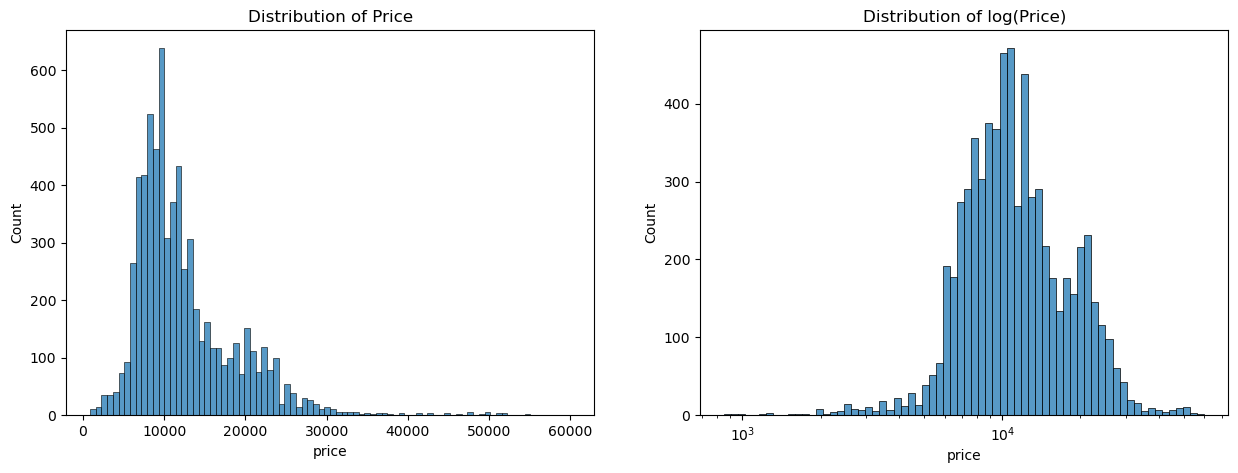

In [8]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.histplot(df['price'],ax=axes[0]).set(title='Distribution of Price')
sns.histplot(df['price'],log_scale=True,ax=axes[1]).set(title='Distribution of log(Price)')

plt.show()

In [9]:
df['price'] = np.log(df['price'])

#### Numerical variables

In [45]:
numeric = df[['price','year','mileage','tax','mpg','engineSize']]

/Users/alessandraginelli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alessandraginelli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alessandraginelli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

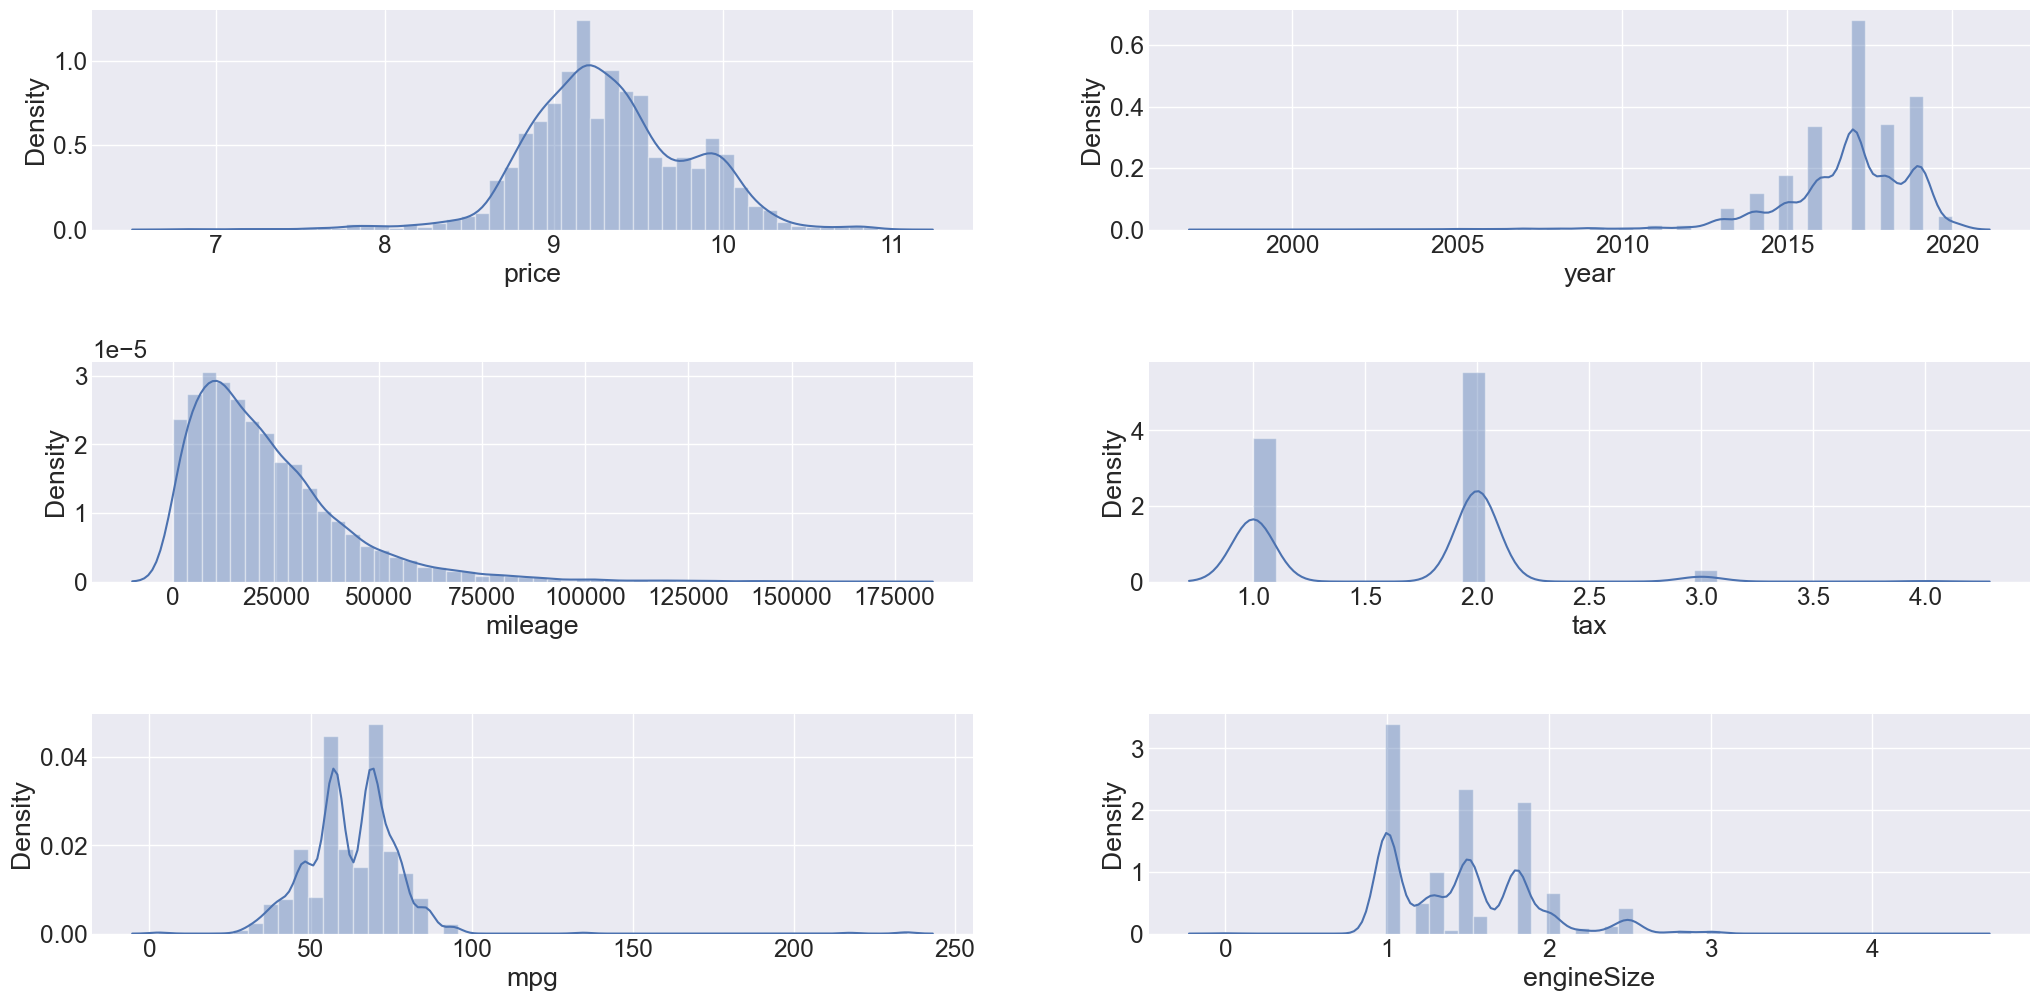

In [46]:
columns = numeric.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3,2, j)
    plt.subplots_adjust(hspace=0.6)
    sns.distplot(numeric[column]);
    
    j += 1

#### Categorical variables

Most common categories are Yaris, Manual, Petrol

In [37]:
cat = df[['transmission','fuelType','model']]

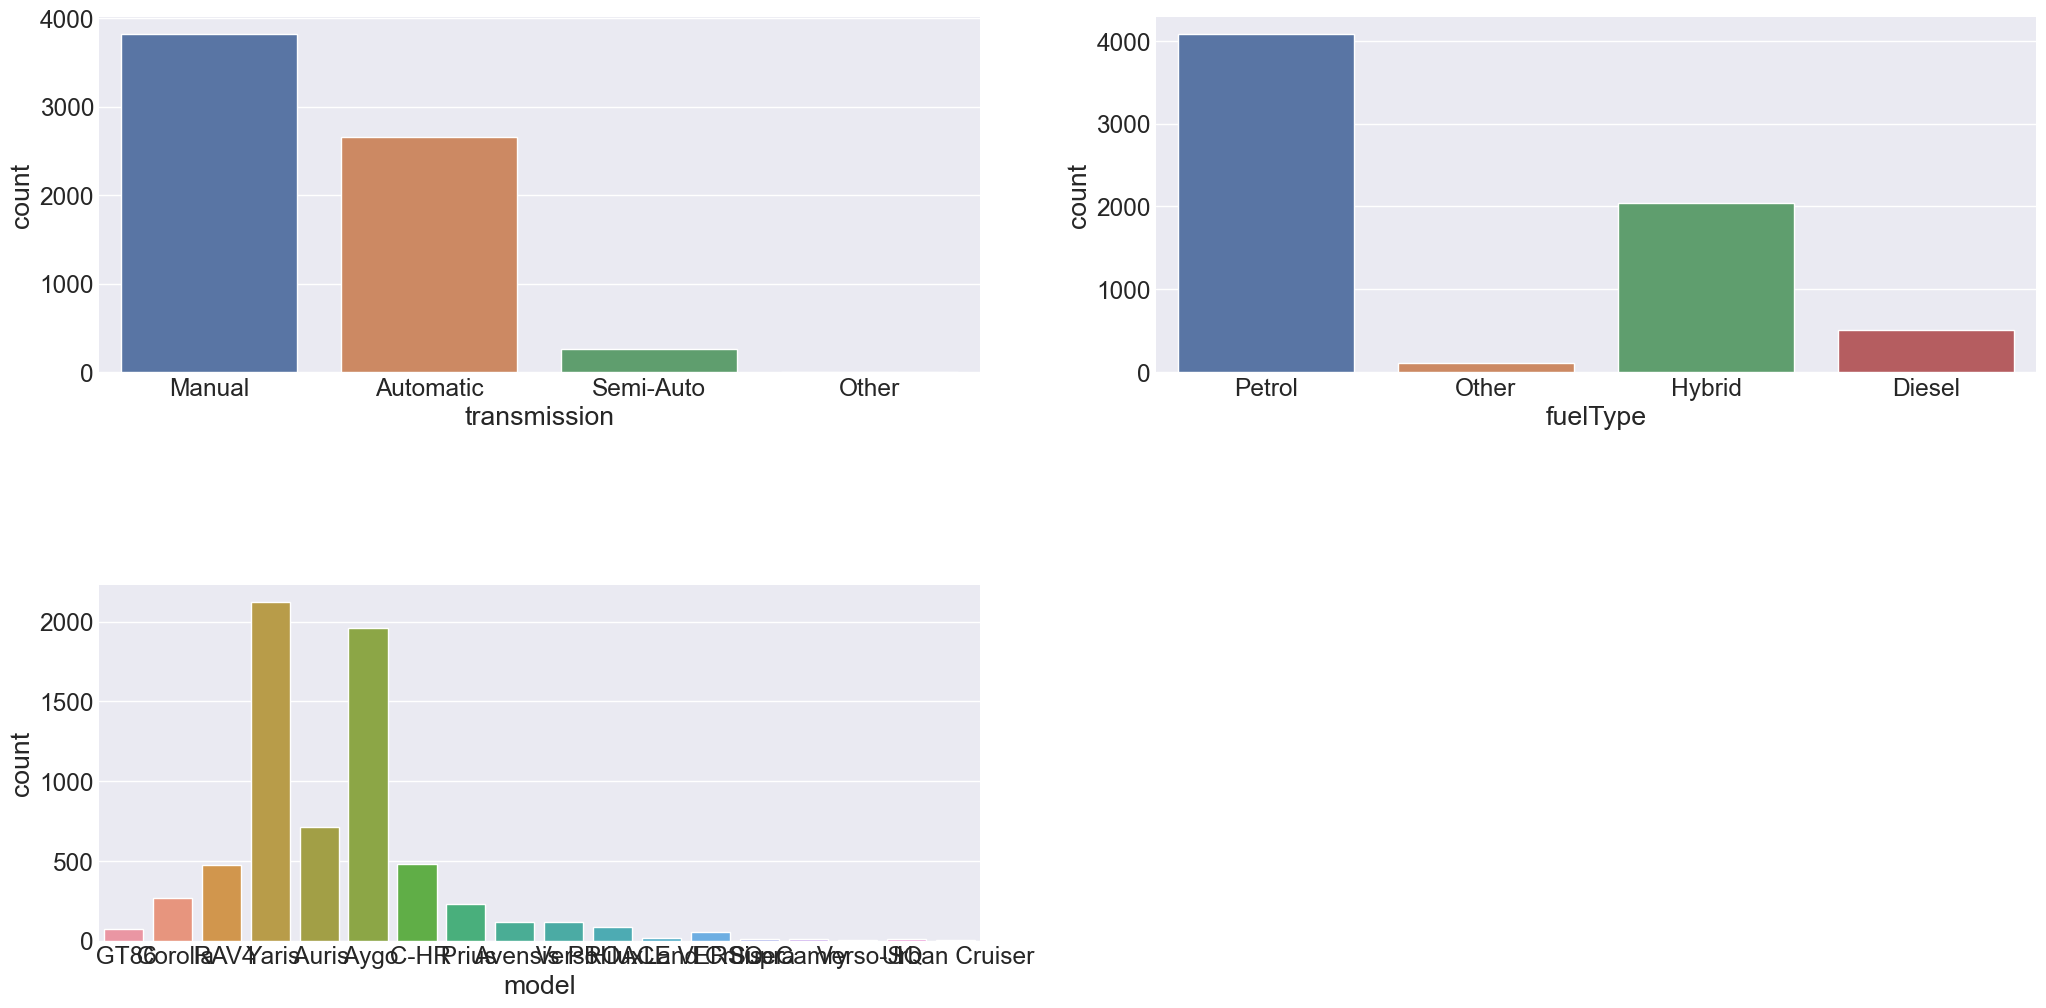

In [38]:
columns = cat.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 2, j)
    plt.subplots_adjust(hspace=0.6)
    ax = sns.countplot(x=column, data=cat)
    
    j += 1

### 2.3 Multivariaty Analysis

#### Numerical variables

We can see negative correlation between _logprice_ and _mileage_. Positive correlation between _logprice_ and _engineSize_.

[Text(0.5, 1.0, 'Correlation Heatmap')]

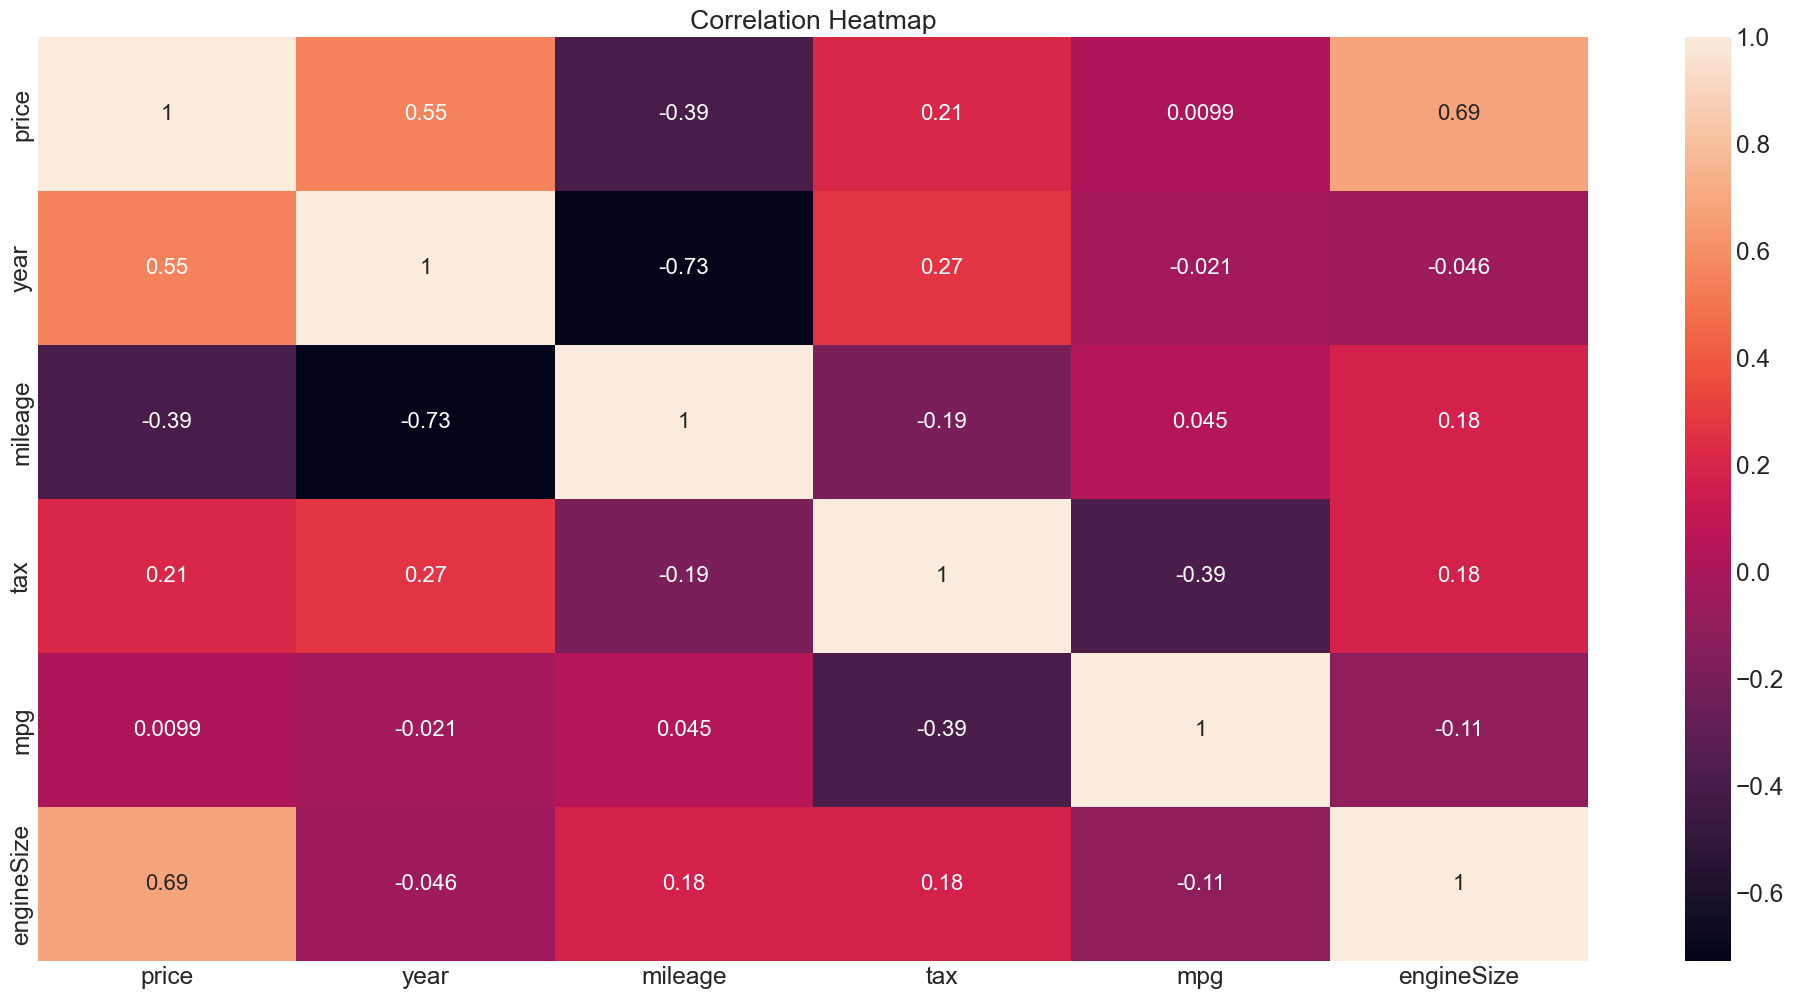

In [47]:
#correlation
sns.heatmap(numeric.corr(),annot=True).set(title='Correlation Heatmap')

Tax vs price shows that tax is divided into 5 different clusters. We change this variable from numeric to ordinal. 

[Text(0.5, 1.0, 'logPrice vs engineSize')]

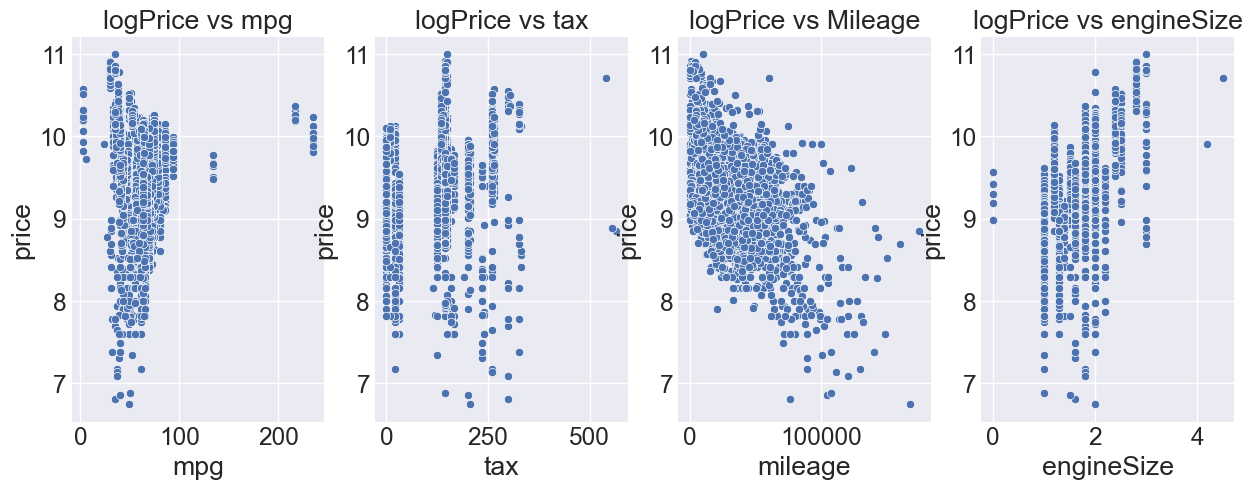

In [42]:
fig, axes = plt.subplots(1,4,figsize=(15,5))
sns.scatterplot(y=df['price'],x=df['mpg'],ax=axes[0]).set(title='logPrice vs mpg')
sns.scatterplot(y=df['price'],x=df['tax'],ax=axes[1]).set(title='logPrice vs tax')
sns.scatterplot(y=df['price'],x=df['mileage'],ax=axes[2]).set(title='logPrice vs Mileage')
sns.scatterplot(y=df['price'],x=df['engineSize'],ax=axes[3]).set(title='logPrice vs engineSize')

In [43]:
# Convert tax variable into an ordinal variable  
df.loc[(df['tax'] <= 100,'tax')] = 1
df.loc[((df['tax'] <= 200) & (df['tax'] > 100) ,'tax')] = 2
df.loc[((df['tax'] <= 300) & (df['tax'] > 200) ,'tax')] = 3
df.loc[(df['tax'] > 300 ,'tax')] = 4

#### Categorical variables

From the boxplots below, we can see there is a difference in distribution of prices among each categories in each variable

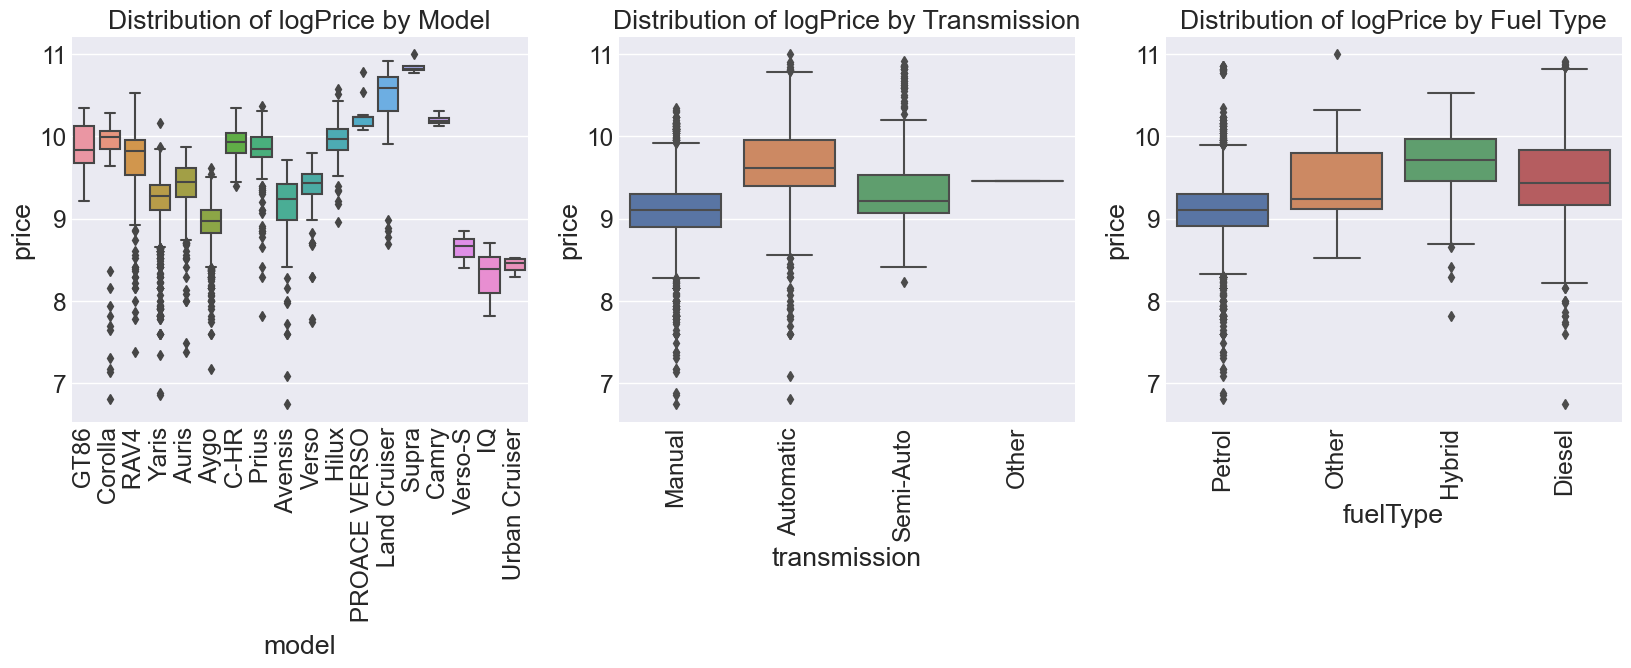

In [44]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.boxplot(data=df, x='model',y='price',ax=axes[0]).set(title='Distribution of logPrice by Model')
sns.boxplot(data=df, x='transmission',y='price',ax=axes[1]).set(title='Distribution of logPrice by Transmission')
sns.boxplot(data=df, x='fuelType',y='price',ax=axes[2]).set(title='Distribution of logPrice by Fuel Type')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

## 3. Data Preparation

* Standardize the numeric features
* Convert the categorical variables into numeric features
* Split the data into a training set and a test set

First two steps are in Pipeline.

### 3.1 Standardization and Encoding

In [70]:
num_features=['year','mileage','mpg','engineSize', 'tax']
cat_features=['model','transmission','fuelType']

# preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

### 3.2 Train/Test split

In [71]:
# select features and target
X = df.drop(columns=['price'])
y = df['price']

feature_cols=X.columns

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
df2=df.copy()

In [62]:
pt=PowerTransformer()
df2[num_features]=pt.fit_transform(df2[num_features])

/Users/alessandraginelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3211: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
/Users/alessandraginelli/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/Users/alessandraginelli/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/alessandraginelli/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [64]:
lb=LabelEncoder()
df2['model']=lb.fit_transform(df2['model'])
df2['transmission']=lb.fit_transform(df2['transmission'])
df2['fuelType']=lb.fit_transform(df2['fuelType'])

In [69]:
lr=LinearRegression()

# train the model
lr.fit(X_train, y_train)

# make predictions on the test set
y_pred_lr = lr.predict(X_test)

# calculate the mean squared error
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("Mean Squared Error Linear Regression: ", rmse_lr)

Mean Absolute Error Linear Regression:  0.13411270770104497
Mean Squared Error Linear Regression:  0.18634186014030843


## 4. Linear Regression Model

In [72]:
lr=LinearRegression()

pipeline_lr = Pipeline([('preprocessor', preprocessor), 
                        ('lr', lr)])

# train the model
pipeline_lr.fit(X_train, y_train)

# make predictions on the test set
y_pred_lr = pipeline_lr.predict(X_test)

# calculate the mean squared error
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("Mean Squared Error Linear Regression: ", rmse_lr)

Mean Squared Error Linear Regression:  0.1032429347033607


### 4.1 Feature Importance

Model is the most important feature

[('engineSize', -0.5610720333959919), ('tax', -0.18083506507260186), ('mpg', -0.1595881209279471), ('year', -0.09881747315003328), ('fuelType', -0.021678024756178662), ('transmission', -0.005282794465001044), ('mileage', 0.05438795716523522), ('model', 0.19808662398134008)]


Text(0.5, 1.0, 'Feature Importance in Linear Regression Model')

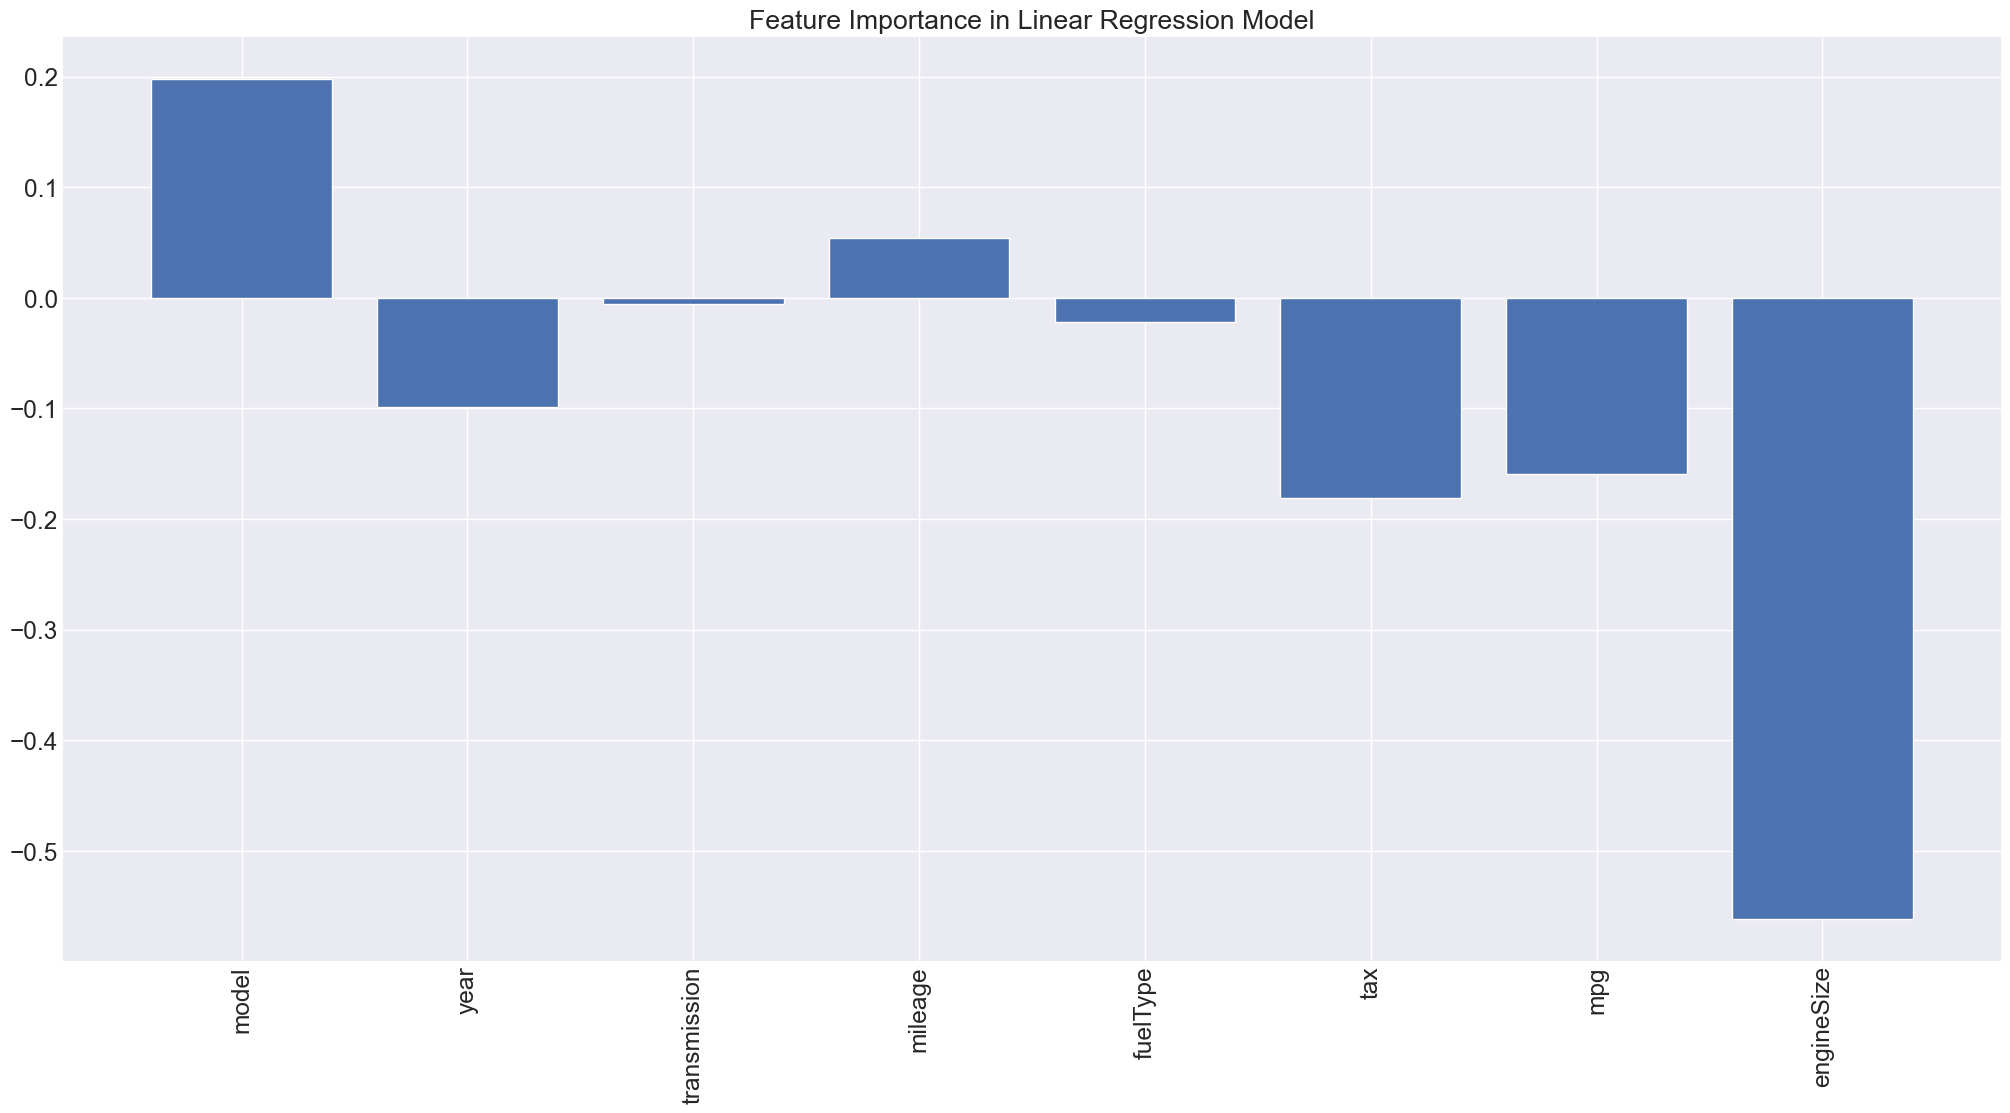

In [73]:
resultdict = {}
for i in range(len(feature_cols)):
    resultdict[feature_cols[i]] = lr.coef_[i]

print(sorted(resultdict.items(), key=lambda x:x[1]))


plt.bar(resultdict.keys(),resultdict.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Linear Regression Model')

# 5. Random Forest Regression Model

KFold and CV for hypertuning model parameters.

In [75]:
# train the model
rf = RandomForestRegressor(random_state=42)

#KFold for grid search
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid = {'max_depth': [2, 5, 10],
        'n_estimators': [10, 50]}

# create pipeline
pipeline = Pipeline([('preprocessor', preprocessor), 
                     ('GridSearchCV', GridSearchCV(estimator=rf, param_grid=grid, cv=kf))])


# train the model
pipeline.fit(X_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(X_test)

# calculate the mean squared error
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
print("Mean Squared Error Random Forest: ", rmse_rf)

Mean Squared Error Random Forest:  0.0916143985393811


Mileage and Model are the most important features.

[('engineSize', 0.0005425383903497553), ('fuelType', 0.004573103136485824), ('mpg', 0.004875926666633216), ('tax', 0.009202878371813649), ('year', 0.03893818271623617), ('transmission', 0.05987610876847962), ('model', 0.32081512100952153), ('mileage', 0.5149460829820846)]


Text(0.5, 1.0, 'Feature Importance in Random Forest Regression Model')

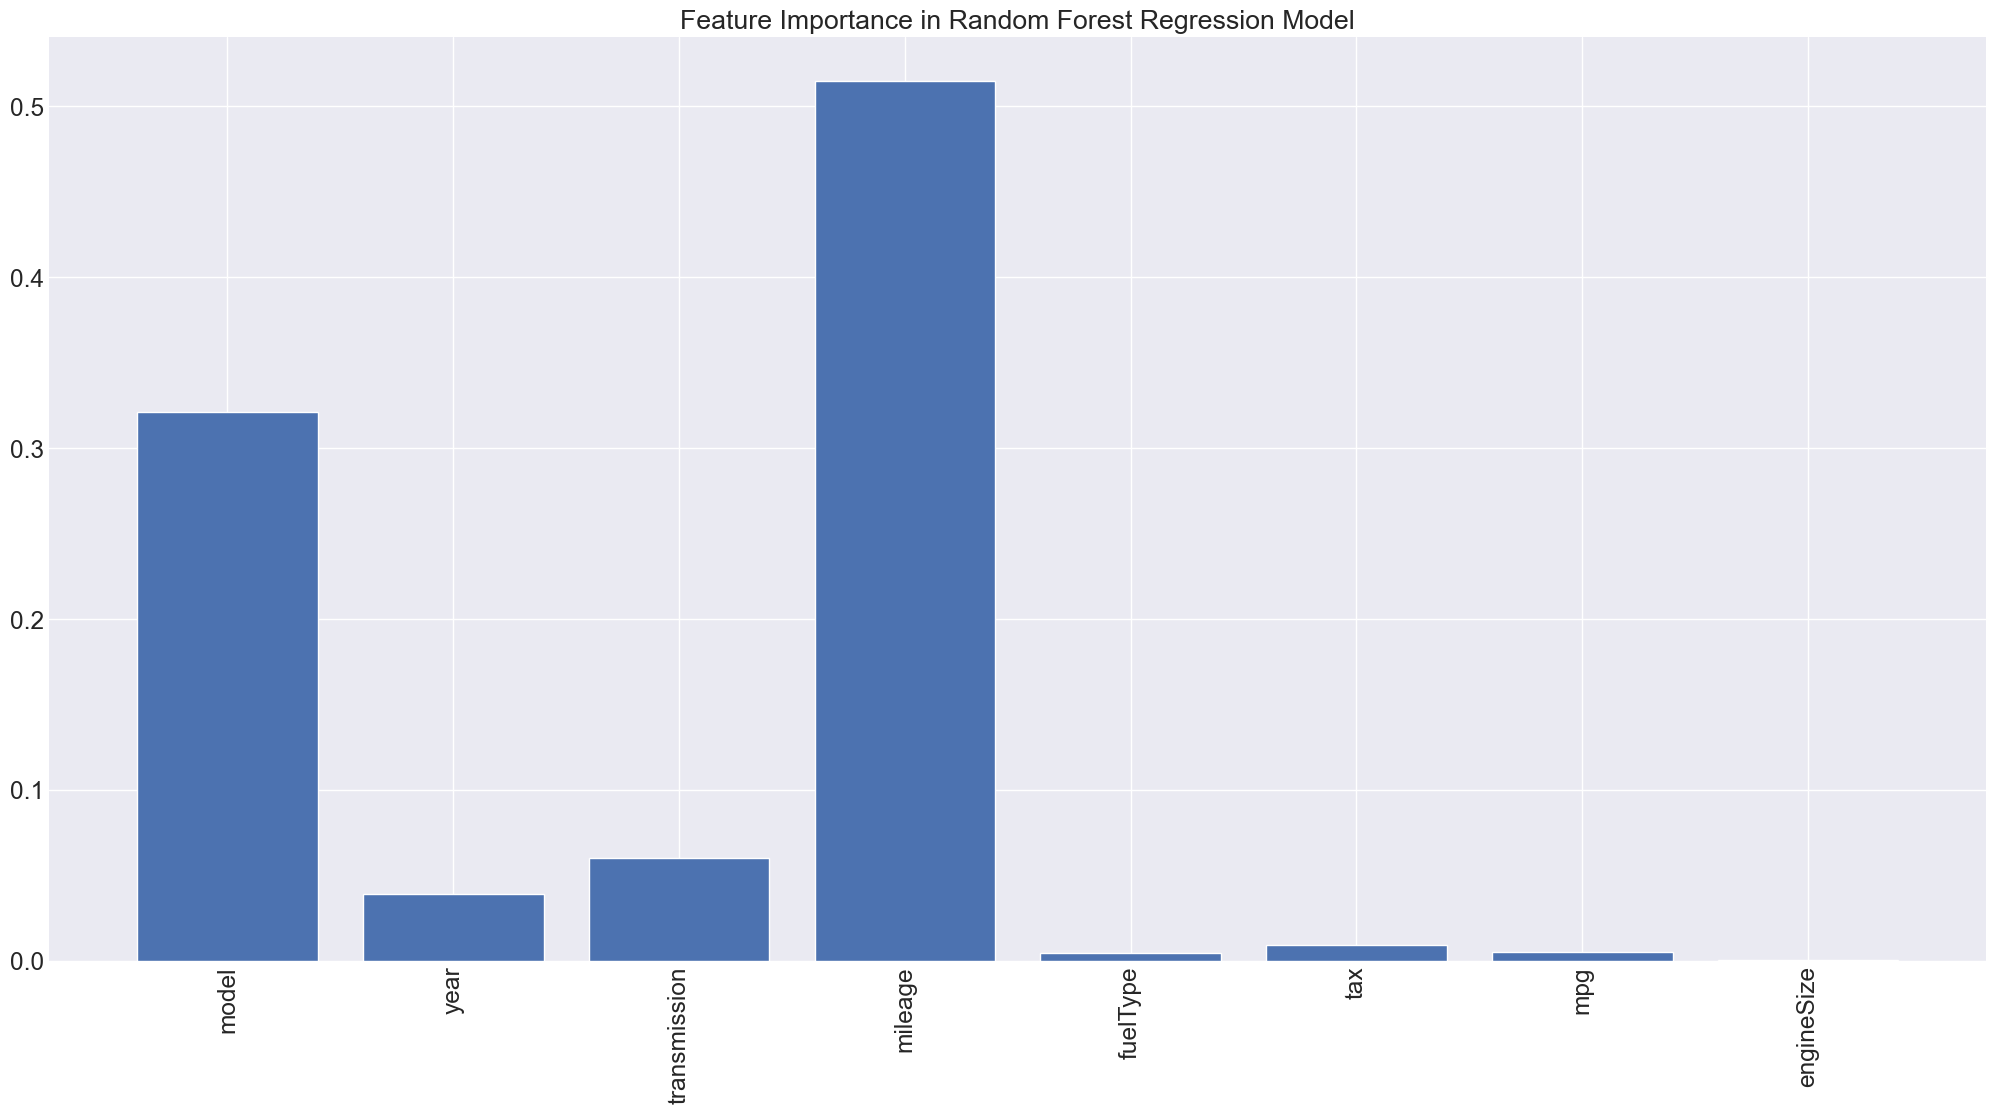

In [76]:
importance = pipeline.named_steps['GridSearchCV'].best_estimator_.feature_importances_

f_importance = {}
for i in range(len(feature_cols)):
     f_importance[feature_cols[i]] = importance[i]
        
print(sorted(f_importance.items(), key=lambda x:x[1]))

plt.bar(f_importance.keys(),f_importance.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Random Forest Regression Model')

# 6. Conclusions

The **RMSE** of the Linear Regression is 0.10, and the Random Forest Regression model is 0.09, meaning the Random Forest Regression model has less error in predicting values.

# 7. Business Evaluation

Business want prices that have maximum 1500$ of error. 
We evaluate both models using business KPI.

In [95]:
y_test2=np.array(y_test)

In [96]:
diff_price['real_p'] = np.round(np.exp(y_test2),0)
diff_price['pred_lr'] = np.round(np.exp(y_pred_lr),0)
diff_price['pred_rf'] = np.round(np.exp(y_pred),0)

In [97]:
diff_price['delta_lr']=diff_price['pred_lr']-diff_price['real_p']
diff_price['delta_rf']=diff_price['pred_rf']-diff_price['real_p']

In [98]:
diff_price['flag_lr']=diff_price['delta_lr']>1500
diff_price['flag_rf']=diff_price['delta_rf']>1500

In [99]:
diff_price['Result_lr'] = diff_price['flag_lr'].apply(lambda x: 'Unsold with LR' if x == True else 'Sold with LR')
diff_price['Result_rf'] = diff_price['flag_rf'].apply(lambda x: 'Unsold with RF' if x == True else 'Sold with RF')

Text(0.5, 1.0, 'Evaluating Linear Tree Regression Model by KPI')

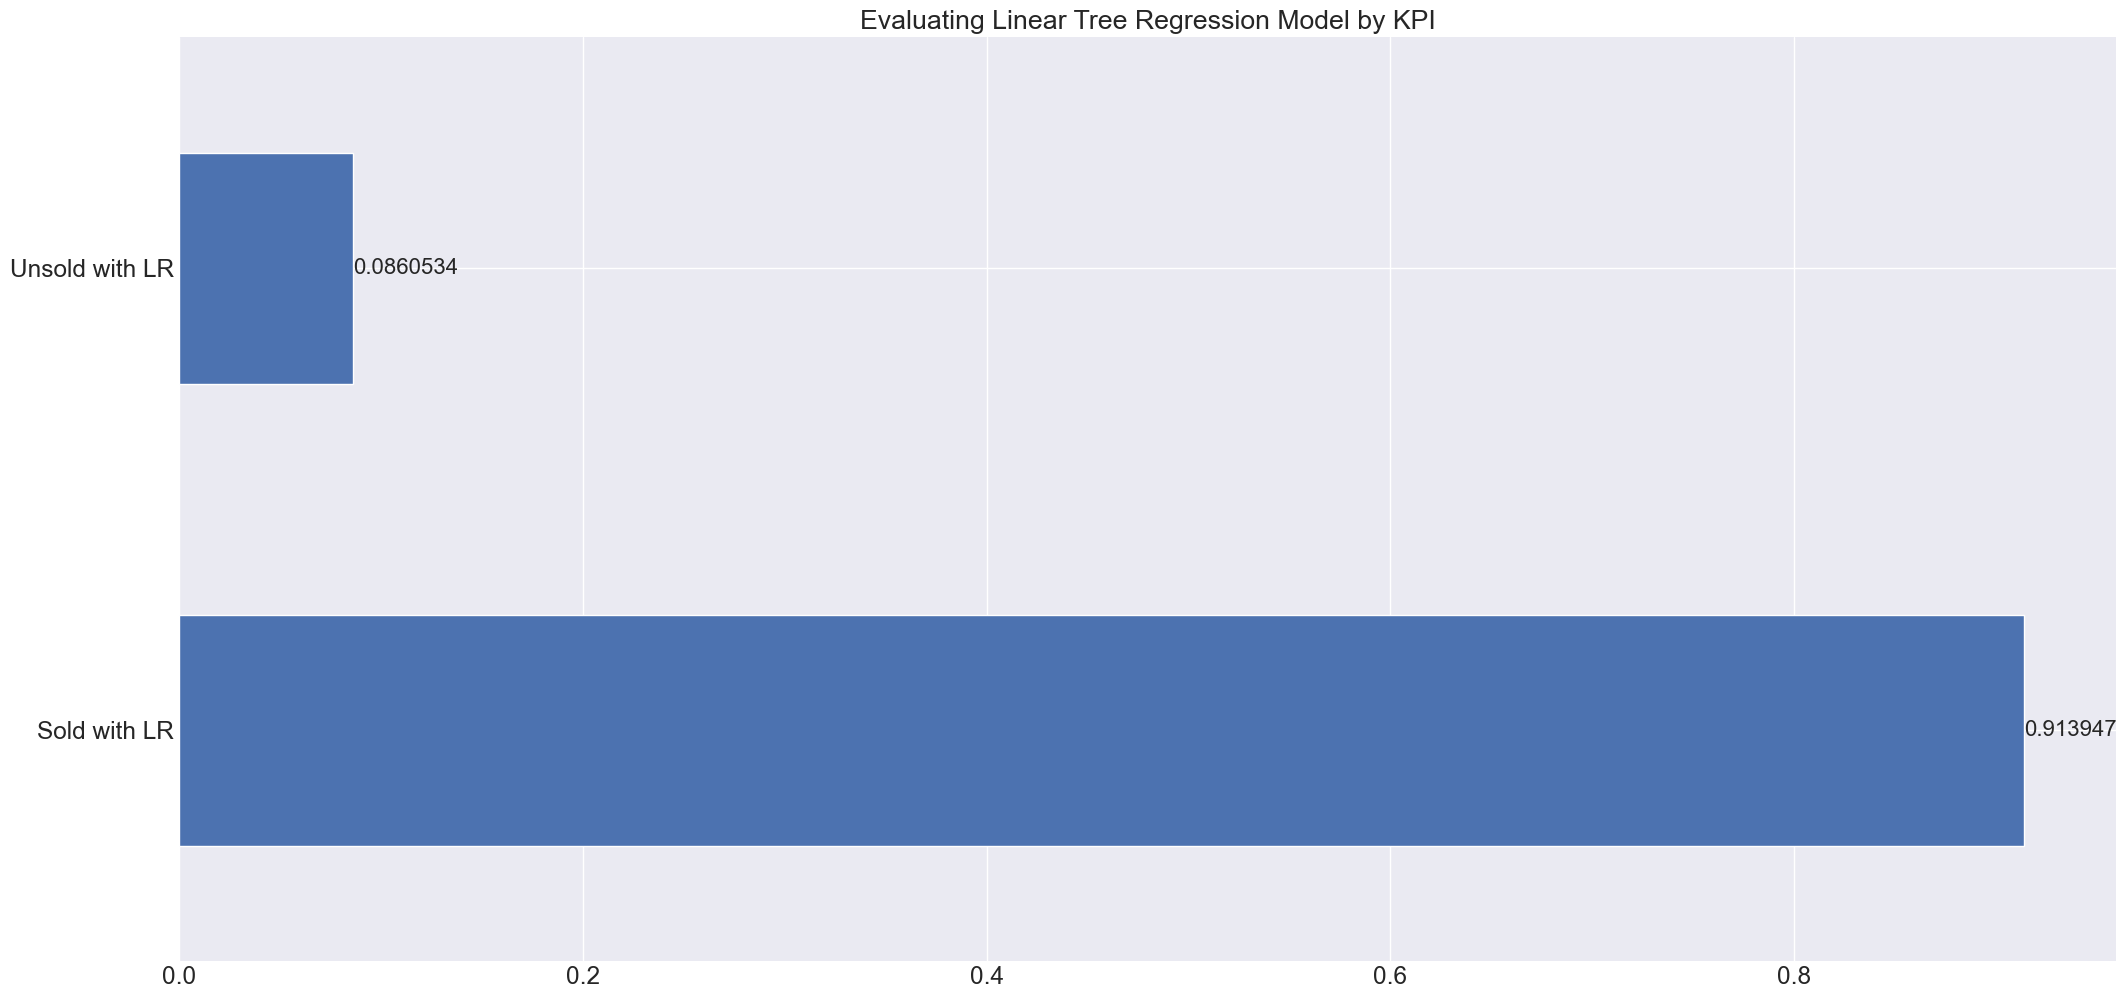

In [103]:
ax = diff_price['Result_lr'].value_counts(normalize=True).plot.barh()
ax.bar_label(ax.containers[0])
ax.set_title('Evaluating Linear Tree Regression Model by KPI')

Text(0.5, 1.0, 'Evaluating Random Forest Tree Regression Model by KPI')

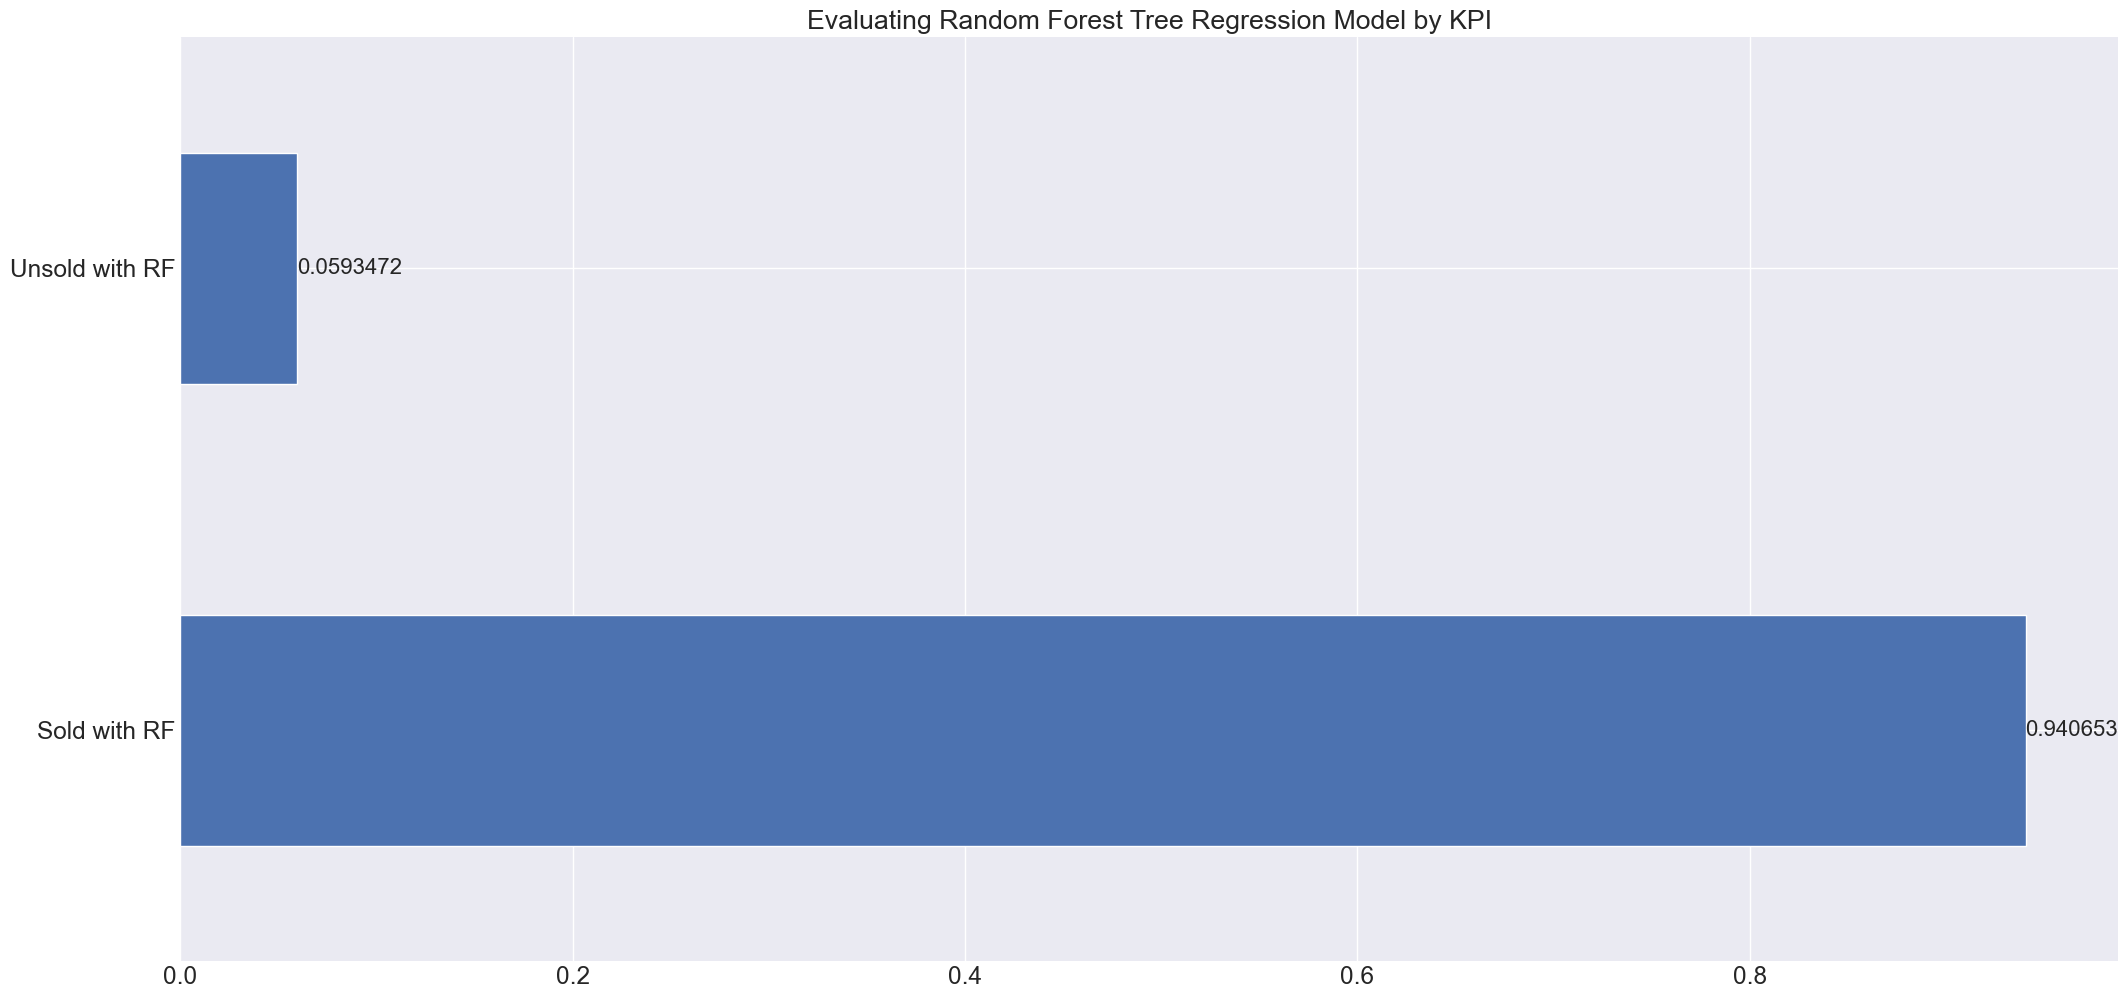

In [104]:
ax = diff_price['Result_rf'].value_counts(normalize=True).plot.barh()
ax.bar_label(ax.containers[0])
ax.set_title('Evaluating Random Forest Tree Regression Model by KPI')

Random Forest Regression model is the best in terms of predictions and business KPIs: 94% of cars will be sold using this model. 